In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA

import matplotlib.pyplot as plt
# グラフを横長にする
plt.rcParams['figure.figsize'] = 15, 6
# 文字サイズの指定
plt.rcParams["font.size"] = 18

## データの読み込み
parse_dates=True: indexの列をdatetime型に変換

In [3]:
data = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv',
                                    index_col='Month', parse_dates=True,  dtype='float')
ts = data['Passengers']

## どんな時系列かプロットしてみる

Text(0, 0.5, 'Passengers')

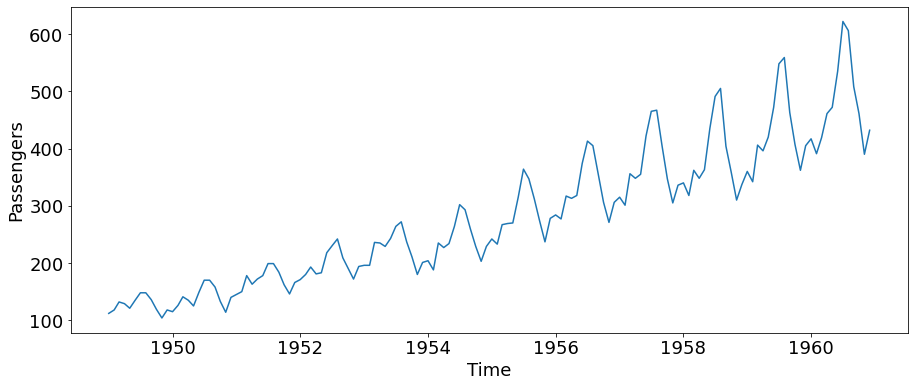

In [4]:
plt.plot(ts)
plt.xlabel('Time')
plt.ylabel('Passengers')

## 自己相関・偏自己相関のコレログラム
- 12ヶ月の周期性が確認できる

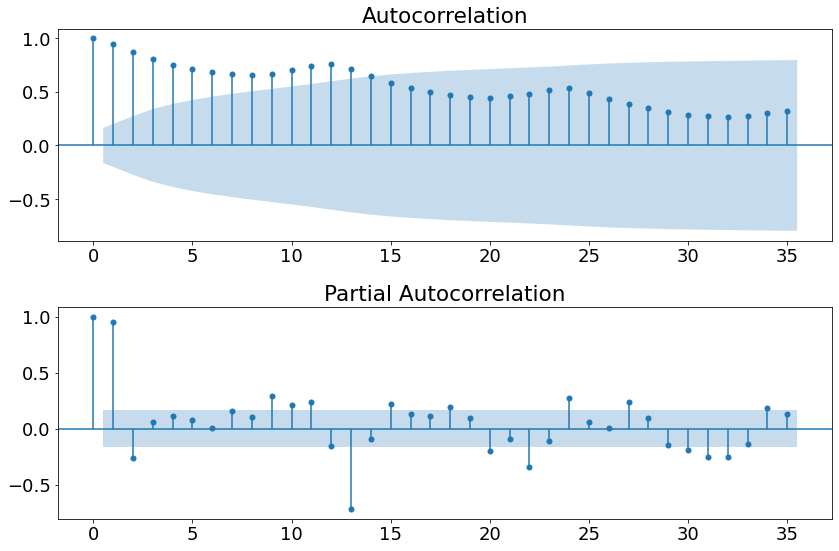

In [5]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ts, lags=35, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ts, lags=35, ax=ax2)
plt.tight_layout()

## 季節成分とトレンド、その残差への分解
- 上記結果の12ヶ月の周期性に基づいて分解

In [6]:
res = seasonal_decompose(ts, model='additive', period=12)

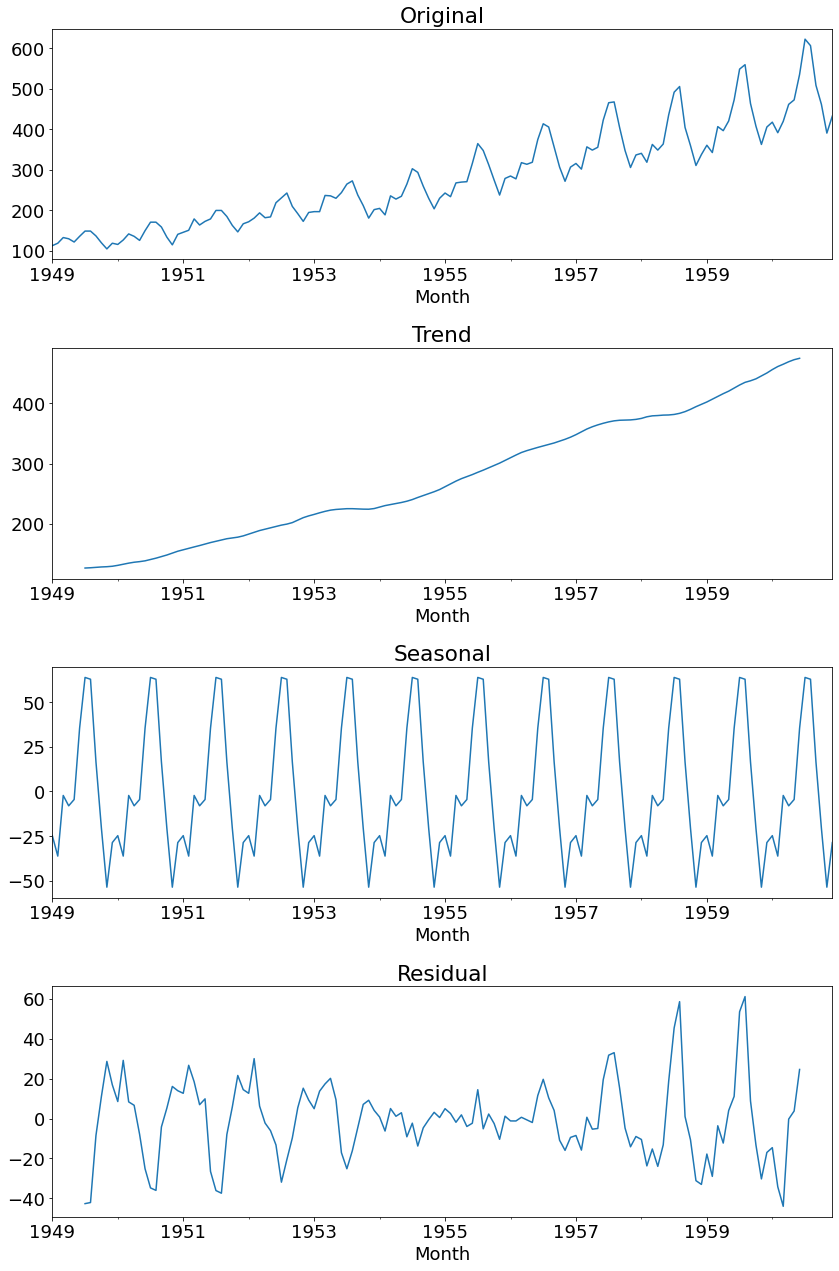

In [7]:
fig = plt.figure(figsize=(12,18))

ax1 = fig.add_subplot(411)
ax1.set_title('Original')
ax1 = res.observed.plot()

ax2 = fig.add_subplot(412)
ax2.set_title('Trend')
ax2 = res.trend.plot()

ax3 = fig.add_subplot(413)
ax3.set_title('Seasonal')
ax3 = res.seasonal.plot()

ax4 = fig.add_subplot(414)
ax4.set_title('Residual')
ax4 = res.resid.plot()

plt.tight_layout()

## 各種モデルで実際に分析していく

### MAモデル
- 推定されたMAパラメータは意味がない（z値が信頼区間の内部にいる）
- MAモデルは定常なので、元からムリゲーな話

In [8]:
ma_mod = ARIMA(ts, order=(0, 0, 2)).fit()
print(ma_mod.summary())

                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  144
Model:                 ARIMA(0, 0, 2)   Log Likelihood                -757.063
Date:                Wed, 10 Mar 2021   AIC                           1522.126
Time:                        15:50:06   BIC                           1534.005
Sample:                    01-01-1949   HQIC                          1526.953
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        280.4095     14.386     19.491      0.000     252.213     308.606
ma.L1          1.3825     23.075      0.060      0.952     -43.844      46.609
ma.L2          1.0000     33.380      0.030      0.9

/Users/t-hayasaka/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/t-hayasaka/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/t-hayasaka/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/t-hayasaka/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:977: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


### ARモデル
- 推定されたARパラメータは信頼度が高い（p値がかなり小さい）
- ARパラメータの係数が

In [9]:
ar_mod = ARIMA(ts, order=(2, 0, 0)).fit()
print(ar_mod.summary())

                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  144
Model:                 ARIMA(2, 0, 0)   Log Likelihood                -702.819
Date:                Wed, 10 Mar 2021   AIC                           1413.639
Time:                        15:50:06   BIC                           1425.518
Sample:                    01-01-1949   HQIC                          1418.466
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        280.2991     54.518      5.141      0.000     173.445     387.153
ar.L1          1.2831      0.079     16.316      0.000       1.129       1.437
ar.L2         -0.3322      0.082     -4.054      0.0

/Users/t-hayasaka/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/t-hayasaka/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/t-hayasaka/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


### 推論してみる
- 上記結果ではデータに対してよくフィッティングできているように思われたが、未知のデータに弱いことがわかる

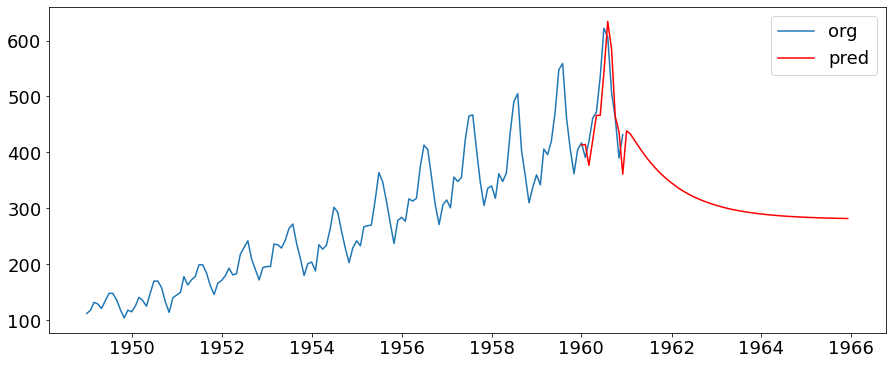

In [10]:
pred = ar_mod.predict('1960-01', '1965-12')
plt.plot(ts, label="org")
plt.plot(pred, "r", label="pred")
plt.legend()

### ARMAモデル
- 推定されたパラメータは、p値だけをみると問題なさそう

In [11]:
arma_mod = ARIMA(ts, order=(1, 0, 1)).fit()
print(arma_mod.summary())

                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  144
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -700.874
Date:                Wed, 10 Mar 2021   AIC                           1409.749
Time:                        15:50:08   BIC                           1421.628
Sample:                    01-01-1949   HQIC                          1414.576
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        280.3009     56.644      4.948      0.000     169.281     391.321
ar.L1          0.9373      0.028     34.009      0.000       0.883       0.991
ma.L1          0.4264      0.076      5.642      0.0

/Users/t-hayasaka/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/t-hayasaka/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/t-hayasaka/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


### 推論してみる
- ARモデル同様、未知データに弱い

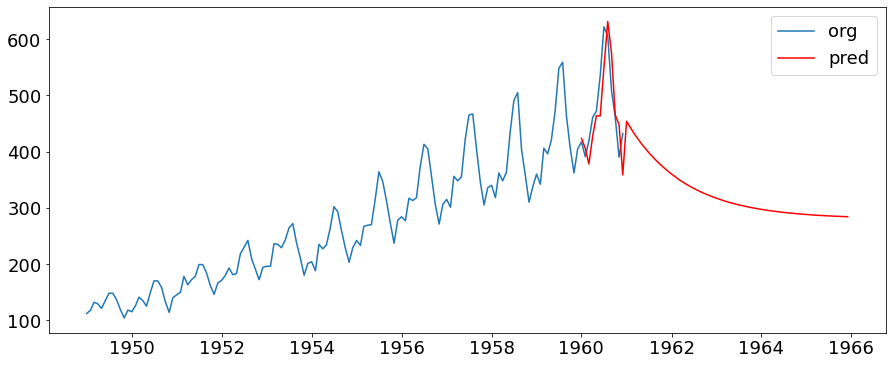

In [12]:
pred = arma_mod.predict('1960-01', '1965-12')
plt.plot(ts, label="org")
plt.plot(pred, "r", label="pred")
plt.legend()

### ARIMAモデル

まずは扱う差分を決める
- 上述の結果より、トレンドが線形になっているので、1次差分を扱う（一次式を微分したら定数になり、定常になる）
- 周期性があるのと、分散が非定常な様子が目視でわかる

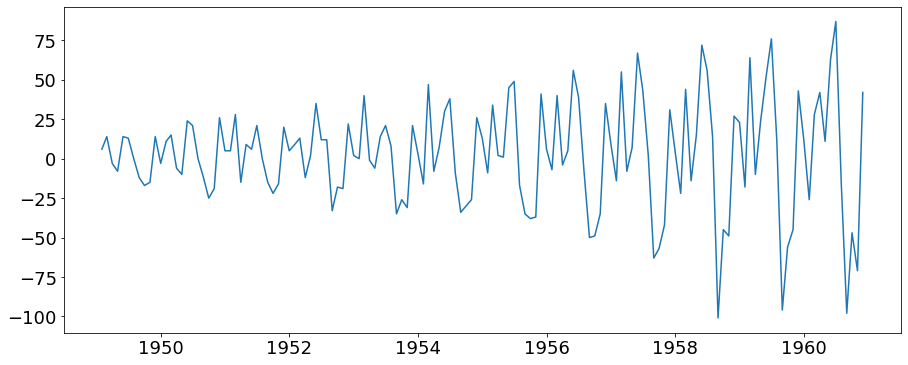

In [13]:
diff1 = ts.diff(periods=1).dropna()
plt.plot(diff1)

$d=1$としたARIMAを適用
- p値は良さげ

In [14]:
arima_mod = ARIMA(ts, order=(1, 1, 1)).fit()
print(arima_mod.summary())

                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  144
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -694.341
Date:                Wed, 10 Mar 2021   AIC                           1394.683
Time:                        15:50:10   BIC                           1403.571
Sample:                    01-01-1949   HQIC                          1398.294
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4742      0.123     -3.847      0.000      -0.716      -0.233
ma.L1          0.8635      0.078     11.051      0.000       0.710       1.017
sigma2       961.9270    107.433      8.954      0.0

/Users/t-hayasaka/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/t-hayasaka/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/t-hayasaka/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


### 推論してみる
- こちらも未知データに弱い
- AR, ARMAと違うのは予測値がほぼ一定になってる点

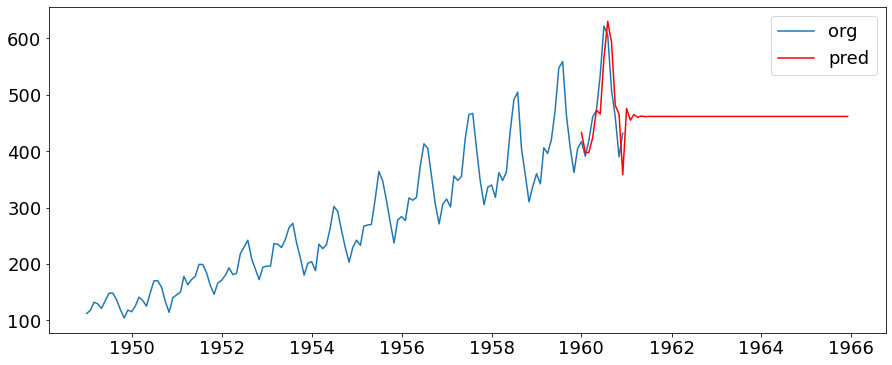

In [15]:
pred = arima_mod.predict('1960-01', '1965-12')
plt.plot(ts, label="org")
plt.plot(pred, "r", label="pred")
plt.legend()

### SARIMAモデル
- パラメータはp値がいい感じになるよう、適当にいじった

In [16]:
sarima_mod = sm.tsa.SARIMAX(ts, order=(2, 1, 1),  seasonal_order=(1, 0, 1, 12), 
                                                        enforce_stationarity = False,  enforce_invertibility = False).fit()
print(sarima_mod.summary())

/Users/t-hayasaka/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/t-hayasaka/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


                                     SARIMAX Results                                      
Dep. Variable:                         Passengers   No. Observations:                  144
Model:             SARIMAX(2, 1, 1)x(1, 0, 1, 12)   Log Likelihood                -488.126
Date:                            Wed, 10 Mar 2021   AIC                            988.253
Time:                                    15:50:12   BIC                           1005.412
Sample:                                01-01-1949   HQIC                           995.225
                                     - 12-01-1960                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3483      0.093    -14.453      0.000      -1.531      -1.165
ar.L2         -0.4541      0.065   

### 推論してみる
- かなりいい感じ

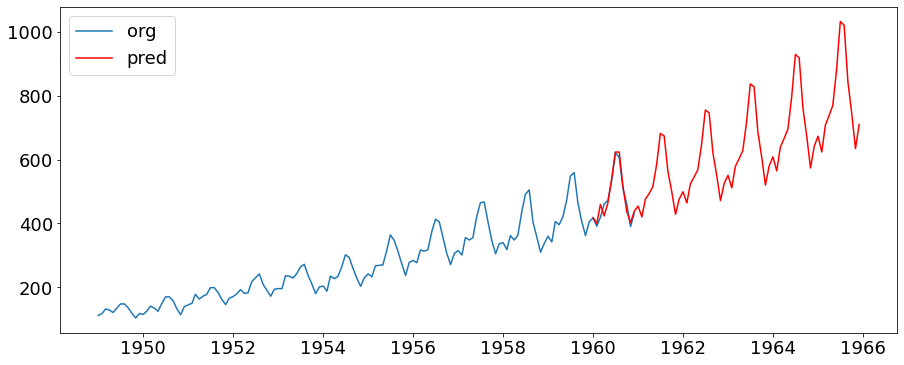

In [17]:
pred = sarima_mod.predict('1960-01', '1965-12')
plt.plot(ts, label="org")
plt.plot(pred, "r", label="pred")
plt.legend()